# Introduction

The GraphBLAS is an API for sparse matrix and vector operations.  This notebook acts as an introduction to the GraphBLAS and also tutorial on how work with graphs in Python using the pygraphblas library.

For an mathematical introduction see [Mathematical Foundations of the GraphBLAS](https://people.eecs.berkeley.edu/~aydin/GraphBLAS-Math.pdf)

In [1]:
from pygraphblas import Matrix, Vector, min_plus, lib, UINT8, BOOL, Accum, min as min_
from pygraphblas.binaryop import min, Accum
from pygraphblas.descriptor import ooco
from pygraphblas.demo.gviz import draw, draw_op

Matrices can be created several different ways, for example literal lists of data can be used to construct them, as shown here:

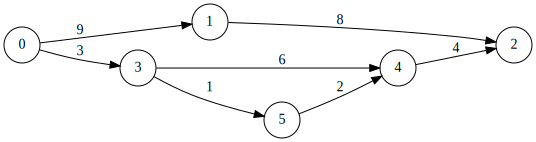

In [2]:
A = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 5],
    [1, 3, 2, 4, 5, 2, 4],
    [9, 3, 8, 6, 1, 4, 2],)

draw(A)

# Adding Matrices

Adding two matrices with the plus operator (`+`) causes the two graphs to be combined together in a union of their nodes.  The default operation when each graph has an edge between the two nodes is to combine them with an addition operator.

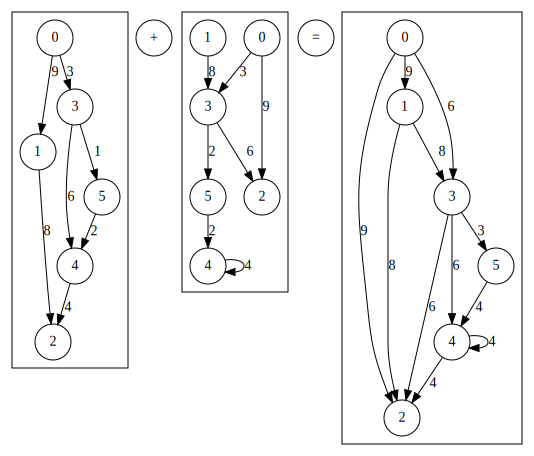

In [3]:
# Construct a suitable B

B = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 5],
    [2, 3, 3, 2, 5, 4, 4],
    [9, 3, 8, 6, 2, 4, 2],)

C = A + B
draw_op(A, '+', B, C)

# Elemenwise Addition using different operators

Elementwise addition can be used in the context of a different binary operator than the default "plus" (`+`) operator:

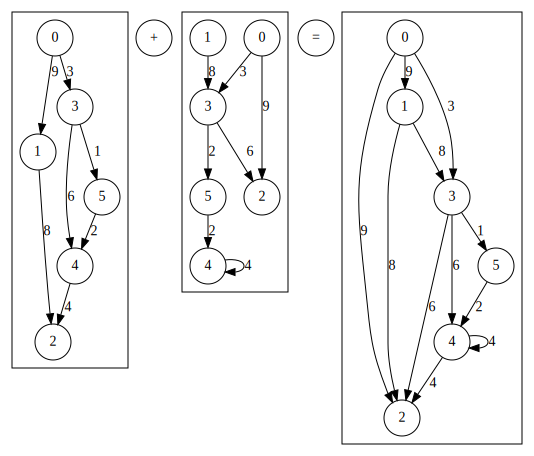

In [4]:
with min_:
    C = A + B
draw_op(A, '+', B, C)

# Elementwise Multiplication

Multiplying two with the star operator (`*`) doeselementwise multiplication, which returns only the intersection of nodes in the two graphs.  Those common nodes will have their weights multiplied.

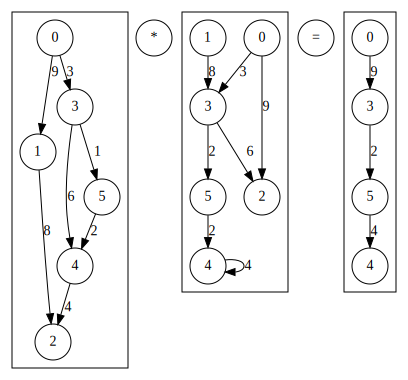

In [5]:
draw_op(A, '*', B, A * B)

# Elementwise Multiplication using different operators

Like addition, elementwise multiplication can use different operators:

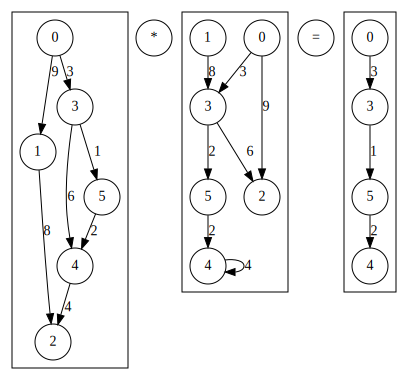

In [6]:
with min:
    C = A * B

draw_op(A, '*', B, C)

# Vector Matrix Multiplication

A Vector can be multiplied on the left by a matrix.  This is row based multiplication.

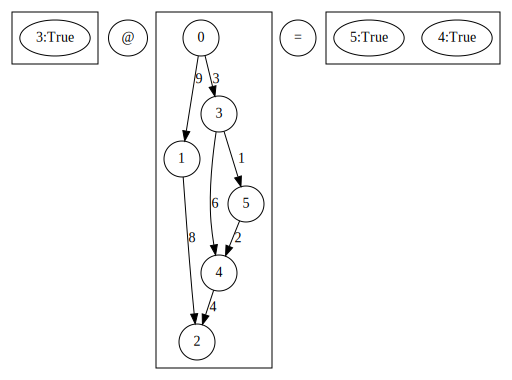

In [7]:
v = Vector.from_lists([3],[True], A.nrows)

draw_op(v, '@', A, v @ A)

# Matrix Vector multiplication

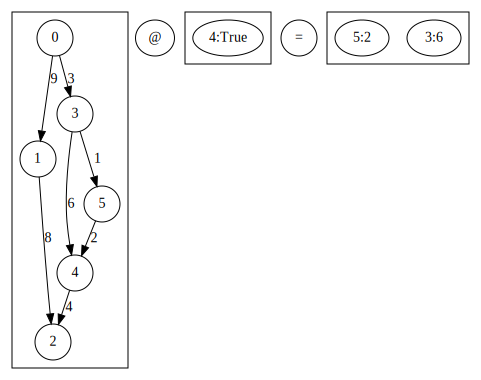

In [8]:
v = Vector.from_lists([4],[True], A.nrows)

draw_op(A, '@', v, A @ v)

# Row vs Column Vector Matrix Multiplication

`Av == vA'` so which direction to go depends on your style and problem.  But it's good to keep in mind these equivalents:

In [9]:
(A @ v == v @ A.transpose()).reduce_bool() and (v @ A == A.transpose() @ v).reduce_bool()

True

# Matrix Multiplication

Multiplying two matrices with the matrix multiplication operator (`@`).

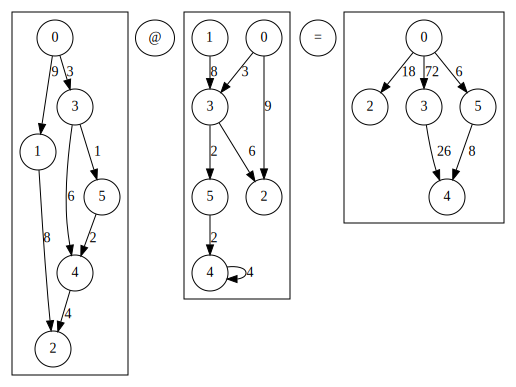

In [10]:
draw_op(A, '@', B, A @ B)

# Semirings

A different semiring can be used during matrix multiplication to get different results. 

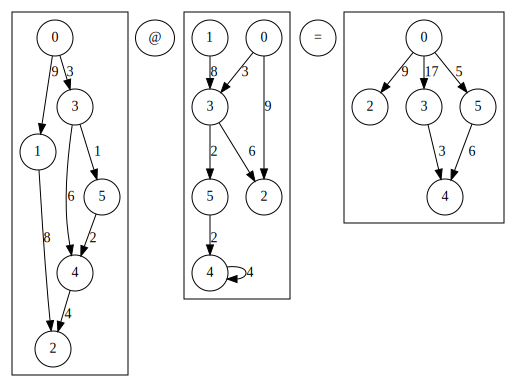

In [11]:
with min_plus:
    g = draw_op(A, '@', B, A @ B)
g

# Transpose

A matrix can be transposed with the `transpose()` method.  This effectively reverses the direction of edges in a graph.

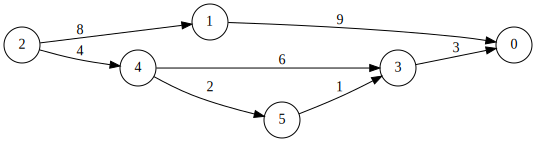

In [12]:
draw(A.transpose())

Adding a graph to it's transpose makes its symmetric, every edge has a corresponding reverse edge.

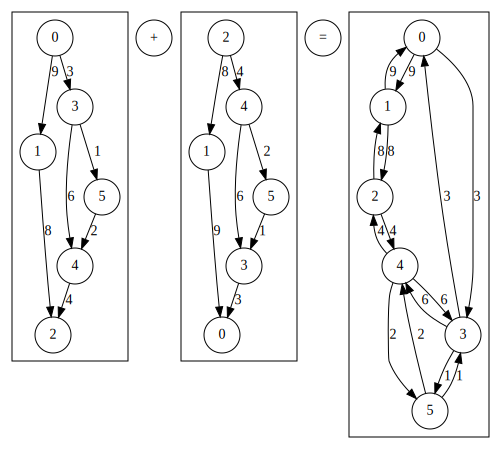

In [13]:
draw_op(A, '+', A.transpose(), A + A.transpose())

# Random Graphs

Random graphs can be constructed with the `from_random` Matrix class method.

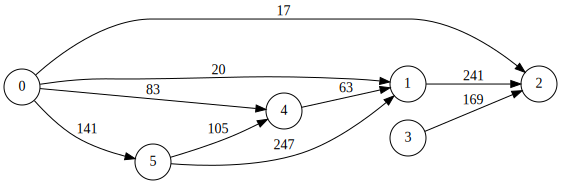

In [14]:
draw(Matrix.from_random(UINT8, 6,6,10, no_diagonal=True, seed=42), show_weight=True)

# Breadth First Search

Matrix multiplication is the basic operation for taking a step across a graph.  This single movement can be combined with a loop to step across an entire graph, tracking the distance from a beginning node to every other node in the graph.  This is called a *Breadth First Search*.

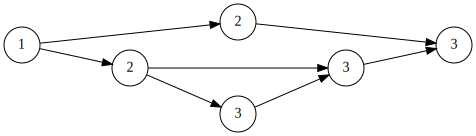

In [15]:

def bfs(matrix, start):
    """Given a graph and a starting position, return a vector of hops to all other nodes."""
    v = Vector.from_type(UINT8, matrix.nrows)   # the result vector
    q = Vector.from_type(BOOL, matrix.nrows)  # a vector to keep track of known nodes
    
    q[start] = True    # we know the distance to the start
    not_done = True
    level = 1
    
    while not_done and level <= matrix.nrows:
        v[:,q] = level                          # Assign the current level to known (q) nodes in v
        q = v.vxm(matrix, mask=v, desc=ooco)    # compliment the mask only find the next unknown nodes
        not_done = q.reduce_bool()              # is q full?
        level += 1                              # increment level
    return v
    
draw(A, show_weight=False, label_vector=bfs(A, 0))

# Shortest Path Length

Using the `min_plus` semiring a similar approach can be used to find the shortest path length between two nodes.  Note how instead of a mask/reduce operation, an equality comparison `iseq` is used to determine if a vector changes from one operation to the next.

In [16]:
def shortest_path_length(matrix, start):
    v = Vector.from_type(matrix.type, matrix.nrows)
    v[start] = 0

    with min_plus, Accum(min):
        for _ in range(matrix.nrows):
            w = Vector.dup(v)
            v @= matrix
            if w.iseq(v):
                break
        return v

draw(A, label_vector=shortest_path_length(A, 0))

AttributeError: cdata 'struct GB_BinaryOp_opaque *' points to an opaque type: cannot read fields